# Training - Facial Emotion Recognition Task

In [43]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt
from keras.models import load_model

In [44]:
import sys
AI_MODEL_ROOT = os.path.join(
    os.path.dirname(os.path.realpath(os.curdir)),
)
sys.path.append(AI_MODEL_ROOT)

In [73]:
import random
import constants
from image_preprocessing import decode_labels
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

## Load the Processed Data

In [46]:
# Define Paths
TRAIN_PATHS = [
    # apollo2506
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'apollo2506',
        'facial-recognition-dataset'
    )
]
VAL_PATH = [
    # tapakah68
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'tapakah68',
        'facial-emotion-recognition'
    )
]
TEST_PATH = [
    # olivetti_faces
    os.path.join(
        os.path.dirname(os.path.realpath(os.curdir)),
        'dataset',
        'olivetti_faces'
    )
]

In [47]:
X_TRAIN = np.array([])
Y_TRAIN = np.array([])
X_TEST = np.array([])
Y_TEST = np.array([])

for path in TRAIN_PATHS:
    print("Extracting Data from", path)
    if 'features' in os.listdir(path):
        X_train_new = np.load(os.path.join(path, 'features', 'X_train.npy'))
        X_test_new = np.load(os.path.join(path, 'features', 'X_test.npy'))

        if X_TRAIN.size == 0:
            X_TRAIN = X_train_new
        else:
            X_TRAIN = np.concatenate((X_TRAIN, X_train_new), axis=0)
            
        if X_TEST.size == 0:
            X_TEST = X_test_new
        else:
            X_TEST = np.concatenate((X_TEST, X_test_new), axis=0)
        print(f"Data Extracted Successfully from {path}")
    if 'label' in os.listdir(path):
        y_train_new = np.load(os.path.join(path, 'label', 'encoded_y_train.npy'))
        y_test_new = np.load(os.path.join(path, 'label', 'encoded_y_test.npy'))

        if Y_TRAIN.size == 0:
            Y_TRAIN = y_train_new
        else:
            Y_TRAIN = np.concatenate((Y_TRAIN, y_train_new), axis=0)
        
        if Y_TEST.size == 0:
            Y_TEST = y_test_new
        else:
            Y_TEST = np.concatenate((Y_TEST, y_test_new), axis=0)
        print(f"Label Extracted Successfully from {path}")


Extracting Data from C:\projects\GenAI\AI_Model\dataset\apollo2506\facial-recognition-dataset
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\apollo2506\facial-recognition-dataset
Label Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\apollo2506\facial-recognition-dataset


In [48]:
print(f"Shape of X_TRAIN: {X_TRAIN.shape}")
print(f"Shape of Y_TRAIN: {Y_TRAIN.shape}")
print(f"Shape of X_TEST: {X_TEST.shape}")
print(f"Shape of Y_TEST: {Y_TEST.shape}")

Shape of X_TRAIN: (28273, 64, 64)
Shape of Y_TRAIN: (28273,)
Shape of X_TEST: (7067, 64, 64)
Shape of Y_TEST: (7067,)


In [49]:
X_VAL = np.array([])
Y_VAL = np.array([])

for path in VAL_PATH:
    print("Extracting Data from", path)
    if 'features' in os.listdir(path):
        X_val_new = np.load(open(os.path.join(path, 'features', 'X_train.npy'), 'rb'))
        X_test_val_new = np.load(open(os.path.join(path, 'features', 'X_test.npy'), 'rb'))
        X_val_new = np.concatenate((X_val_new, X_test_val_new), axis=0)
        if X_VAL.size == 0:
            X_VAL = X_val_new
        else:
            X_VAL = np.concatenate((X_VAL, X_val_new), axis=0)
    if 'labels' in os.listdir(path):
        y_val_new = np.load(open(os.path.join(path, 'labels', 'y_train.npy'), 'rb'))
        y_test_val_new = np.load(open(os.path.join(path, 'labels', 'y_test.npy'), 'rb'))
        y_val_new = np.concatenate((y_val_new, y_test_val_new), axis=0)
        if Y_VAL.size == 0:
            Y_VAL = y_val_new
        else:
            Y_VAL = np.concatenate((Y_VAL, y_val_new), axis=0)
    print(f"Data Extracted Successfully from {path}")
assert X_VAL.shape[0] == Y_VAL.shape[0]

Extracting Data from C:\projects\GenAI\AI_Model\dataset\tapakah68\facial-emotion-recognition
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\tapakah68\facial-emotion-recognition


In [50]:
X_VAL.shape, Y_VAL.shape

((304, 64, 64), (304,))

In [51]:
for path in TEST_PATH:
    print("Extracting Data from", path)
    if 'features' in os.listdir(path):
        X_test_new = np.load(open(os.path.join(path, 'features', 'olivetti_faces_preprocessed.npy'), 'rb'))
        if X_TEST.size == 0:
            X_TEST = X_test_new
        else:
            X_TEST = np.concatenate((X_TEST, X_test_new), axis=0)
        print(f"Data Extracted Successfully from {path}")
    if 'label' in os.listdir(path):
        y_test_new = np.load(open(os.path.join(path, 'label', 'emotion_label.npy'), 'rb'))
        if Y_TEST.size == 0:
            Y_TEST = y_test_new
        else:
            Y_TEST = np.concatenate((Y_TEST, y_test_new), axis=0)
        print(f"Label Extracted Successfully from {path}")
assert X_TEST.shape[0] == Y_TEST.shape[0]

Extracting Data from C:\projects\GenAI\AI_Model\dataset\olivetti_faces
Data Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\olivetti_faces
Label Extracted Successfully from C:\projects\GenAI\AI_Model\dataset\olivetti_faces


In [52]:
X_TEST.shape, Y_TEST.shape

((7467, 64, 64), (7467,))

## Load the Network from Human Face Detection as the Non-Trainable base model

In [53]:
# Load the model from the .h5 file
model_path = os.path.join(
    AI_MODEL_ROOT,
    'human_face_detection_model.h5'
)
model = load_model(model_path)

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,820 (1.57 MB)

 Trainable params: 410,818 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [54]:
# Set the existing layers as non-trainable
for layer in model.layers:
    layer.trainable = False

In [55]:
# Check to make sure layers are non-trainable
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: conv2d, Trainable: False
Layer: max_pooling2d, Trainable: False
Layer: conv2d_1, Trainable: False
Layer: max_pooling2d_1, Trainable: False
Layer: flatten, Trainable: False
Layer: dense, Trainable: False
Layer: dense_1, Trainable: False
Layer: dense_2, Trainable: False


In [56]:
# Add new layers for multi-class classification
num_classes = 8
new_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(64, 64, 1)),  # Assuming input shape is (64, 64, 1)
    model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    # Assuming 8 classes for emotion recognition
    # including Unknown
    keras.layers.Dense(num_classes, activation='softmax')
])
new_model.summary()

c:\projects\GenAI\genai-venv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 2)              │       410,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,234 (1.57 MB)

 Trainable params: 1,416 (5.53 KB)

 Non-trainable params: 410,818 (1.57 MB)

In [57]:
# Compile the new model
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])

# Print the new model summary
new_model

<Sequential name=sequential_1, built=True>

In [58]:
'''# Using Early stopping to reduce the training time'''

call = EarlyStopping(
    min_delta=0.005,
    patience=5,
    verbose=1
)

# Measuring the time taken by the model to train
StartTime=time.time()

'''# Model Training'''
history = new_model.fit(
    X_TRAIN, Y_TRAIN,
    epochs=30,
    validation_data=(X_VAL, Y_VAL),
    callbacks=[call]
)

Endtime = time.time()
print('Total Training Time taken: ',round((Endtime-StartTime)/60),'Minutes')

Epoch 1/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Accuracy: 0.2418 - loss: 1.8490 - val_Accuracy: 0.1250 - val_loss: 3.0619
Epoch 2/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Accuracy: 0.2512 - loss: 1.7668 - val_Accuracy: 0.1250 - val_loss: 3.3936
Epoch 3/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Accuracy: 0.2600 - loss: 1.7564 - val_Accuracy: 0.1250 - val_loss: 3.5213
Epoch 4/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Accuracy: 0.2549 - loss: 1.7616 - val_Accuracy: 0.1250 - val_loss: 3.7184
Epoch 5/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Accuracy: 0.2563 - loss: 1.7578 - val_Accuracy: 0.1250 - val_loss: 3.7935
Epoch 6/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Accuracy: 0.2552 - loss: 1.7570 - val_Accuracy: 0.1250 - val_loss: 3.8255
Epoch 6: early stopping
Total Training Time taken:  0 Minutes


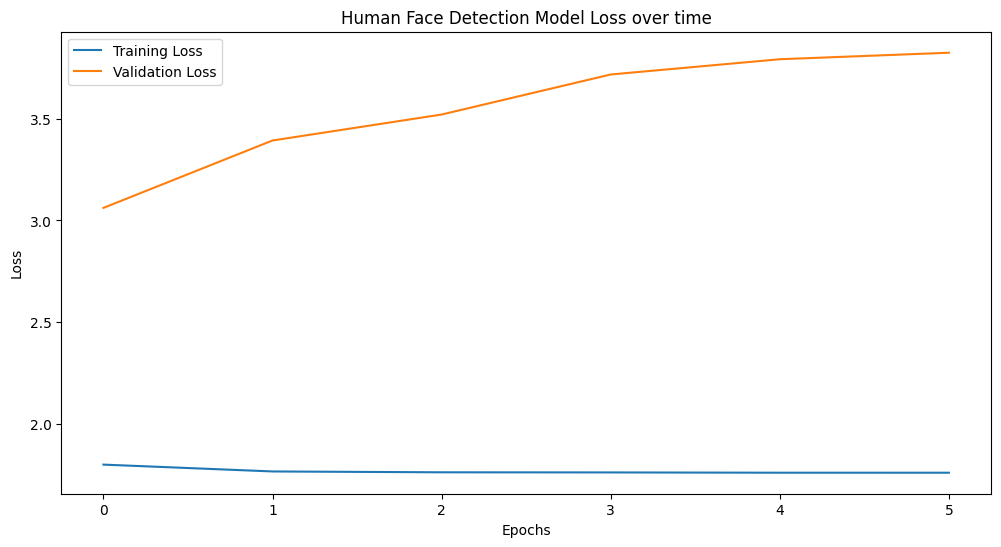

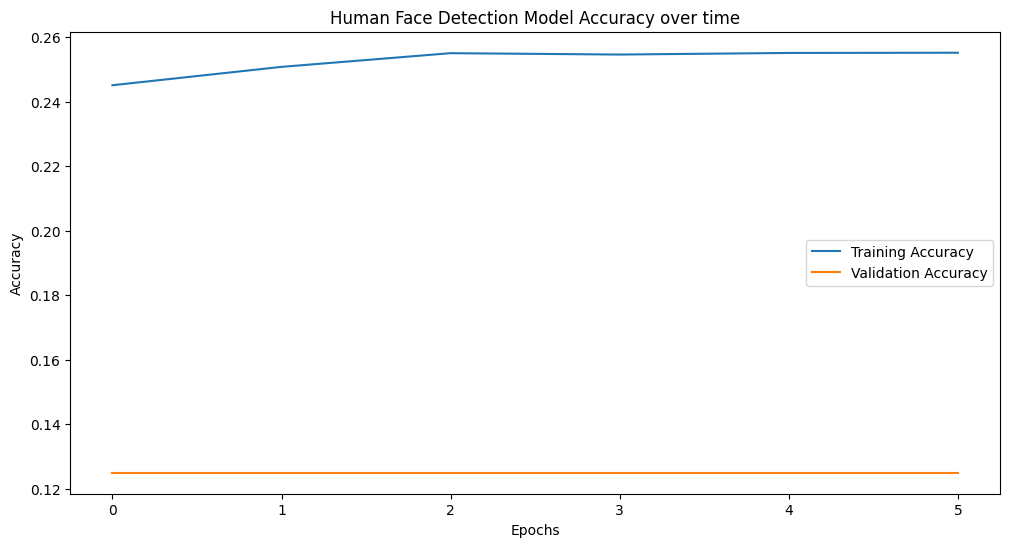

In [59]:
# Plotting Loss over time
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Human Face Detection Model Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Human Face Detection Model Accuracy over time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
# Save the Model
new_model.save(os.path.join(AI_MODEL_ROOT, 'facial_emotion_recognition_model.h5'))
print("Model Saved Successfully!")

Model Saved Successfully!


## Evaluating the Model

In [61]:
# Make Predictions
pred = new_model.predict(X_TEST)
pred

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[1.42338559e-01, 1.37127787e-01, 2.56807476e-01, ...,
        1.15596928e-01, 3.98447446e-05, 4.35546281e-05],
       [1.44154504e-01, 1.32840410e-01, 2.51234055e-01, ...,
        1.25760198e-01, 5.77888131e-05, 5.91085918e-05],
       [1.44159585e-01, 1.36933610e-01, 2.56721437e-01, ...,
        1.13506518e-01, 3.27594134e-05, 3.57728277e-05],
       ...,
       [1.44250542e-01, 1.36910260e-01, 2.56706715e-01, ...,
        1.13406084e-01, 3.24446701e-05, 3.54237272e-05],
       [1.44171774e-01, 1.36930600e-01, 2.56719351e-01, ...,
        1.13493122e-01, 3.27182133e-05, 3.57270583e-05],
       [1.43147483e-01, 1.37129784e-01, 2.56819457e-01, ...,
        1.14640675e-01, 3.65120140e-05, 3.99101154e-05]],
      shape=(7467, 8), dtype=float32)

In [62]:
# One-Hot Decode the Predictions
pred = np.argmax(pred, axis=1)
pred

array([2, 2, 2, ..., 2, 2, 2], shape=(7467,))

In [63]:
evalArray = pred == Y_TEST

In [64]:
# Check the distribution of true labels in Y_TEST
unique, counts = np.unique(Y_TEST, return_counts=True)
label_distribution = dict(zip(unique, counts))

print(label_distribution)

{np.int64(0): np.int64(1358), np.int64(1): np.int64(1024), np.int64(2): np.int64(1774), np.int64(3): np.int64(1233), np.int64(4): np.int64(1247), np.int64(5): np.int64(831)}


Since our model did not make predictions on class 6 and 7 from the test data, we append 0 count to them.

In [67]:
# Append count for class 6 and class 7 to be 0
for i in range(8):
    if i not in label_distribution.keys():
        label_distribution[i] = np.int64(0)

In [68]:
print(label_distribution)

{np.int64(0): np.int64(1358), np.int64(1): np.int64(1024), np.int64(2): np.int64(1774), np.int64(3): np.int64(1233), np.int64(4): np.int64(1247), np.int64(5): np.int64(831), 6: np.int64(0), 7: np.int64(0)}


Accuracy: 0.23757867952323558
Precision: 0.03959644658720593
Recall: 0.16666666666666666
Macro F1 Score: 0.06399018865202179
Micro F1 Score: 0.23757867952323558


c:\projects\GenAI\genai-venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\projects\GenAI\genai-venv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\projects\GenAI\genai-venv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


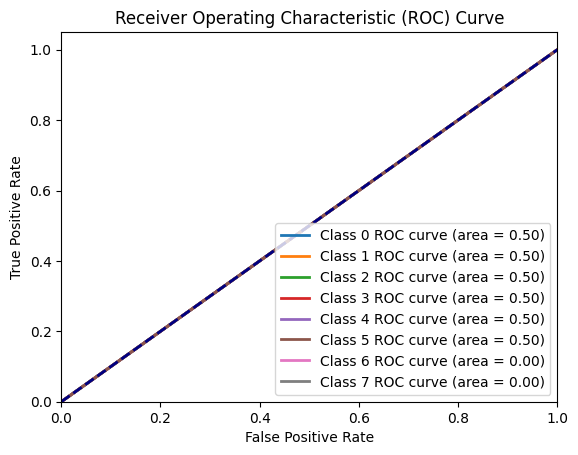

In [72]:
# Decode the Labels with Label Encoder
encoderTest_apollo = pickle.load(open(os.path.join(
    AI_MODEL_ROOT, 
    'dataset',
    'apollo2506',
    'facial-recognition-dataset',
    'encoder_y_test.pkl'
), 'rb'))
encoderTest_tapakah = np.load(open(os.path.join(
    AI_MODEL_ROOT, 
    'dataset',
    'tapakah68',
    'facial-emotion-recognition',
    'encoders',
    'encoder_test.npy'
), 'rb'), allow_pickle=True)

# X_TEST is a combination of both the datasets
# Y_TEST is the ground truth
# Goal: compare the predictions with the ground truth
# Evaluate accuracy
accuracy = accuracy_score(Y_TEST, pred)
print(f"Accuracy: {accuracy}")

# Evaluate precision
precision = precision_score(Y_TEST, pred, average='macro')
print(f"Precision: {precision}")

# Evaluate recall
recall = recall_score(Y_TEST, pred, average='macro')
print(f"Recall: {recall}")

# Evaluate macro and micro F1 scores
macro_f1 = f1_score(Y_TEST, pred, average='macro')
micro_f1 = f1_score(Y_TEST, pred, average='micro')
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

# One-hot encode the true labels and predictions
Y_TEST_one_hot = keras.utils.to_categorical(Y_TEST, num_classes=num_classes)
pred_one_hot = keras.utils.to_categorical(pred, num_classes=num_classes)

# Plot ROC-AUC curve for each class
plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(Y_TEST_one_hot[:, i], pred_one_hot[:, i])
    roc_auc = auc(fpr, tpr)
    if np.isnan(roc_auc):
        roc_auc = 0.0
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Predicting the 286 image from test set: 


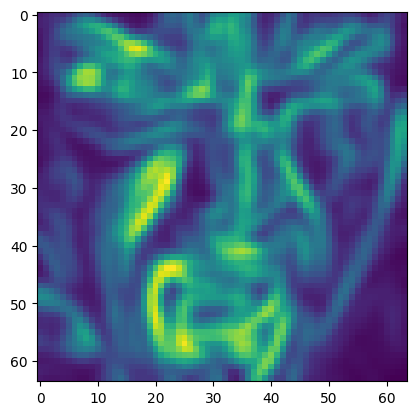

ValueError: y contains previously unseen labels: [2]

In [ ]:
# Show a random prediction in human readable format
index = random.randint(0, len(pred))
image = X_TEST[index]
pred_item = pred[index]
actual_item = Y_TEST[index]
print(f"Predicting the {index} image from test set: ")
plt.imshow(image)
plt.show()

encoder = encoderTest_apollo
pred_item_text = decode_labels(
    encoded_labels=[pred_item],
    encoder=encoder
)[0]
actual_item_text = decode_labels(
    encoded_labels=[actual_item],
    encoder=encoder
)[0]
print(f"The above image is predicted as: {pred_item_text}")
print(f"The actual label of the image is: {actual_item_text}")